# Vertex AI - Experiments > Studies
## Using Vertex Vizier

---
## Setup

In [7]:
from google.cloud import aiplatform_v1beta1 as aipv1
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Locations
REGION = 'us-central1'
PROJECT_ID='statmike-mlops'

ENDPOINT = REGION + "-aiplatform.googleapis.com"
PARENT ="projects/{}/locations/{}".format(PROJECT_ID, REGION)

In [9]:
vizier = aipv1.VizierServiceClient(
    client_options = {"api_endpoint" : ENDPOINT}
)

---
## Challenge
Two functions: y1, y2
What is the value of `r` and `theta` than minimizes `y1` while maximizing `y2`

In [10]:
r = np.linspace(0,1,100)
theta = np.linspace(0,np.pi/2,100)

R, THETA = np.meshgrid(r, theta)

In [11]:
y1 = R * np.sin(THETA)
y2 = R * np.cos(THETA)

<function matplotlib.pyplot.show(close=None, block=None)>

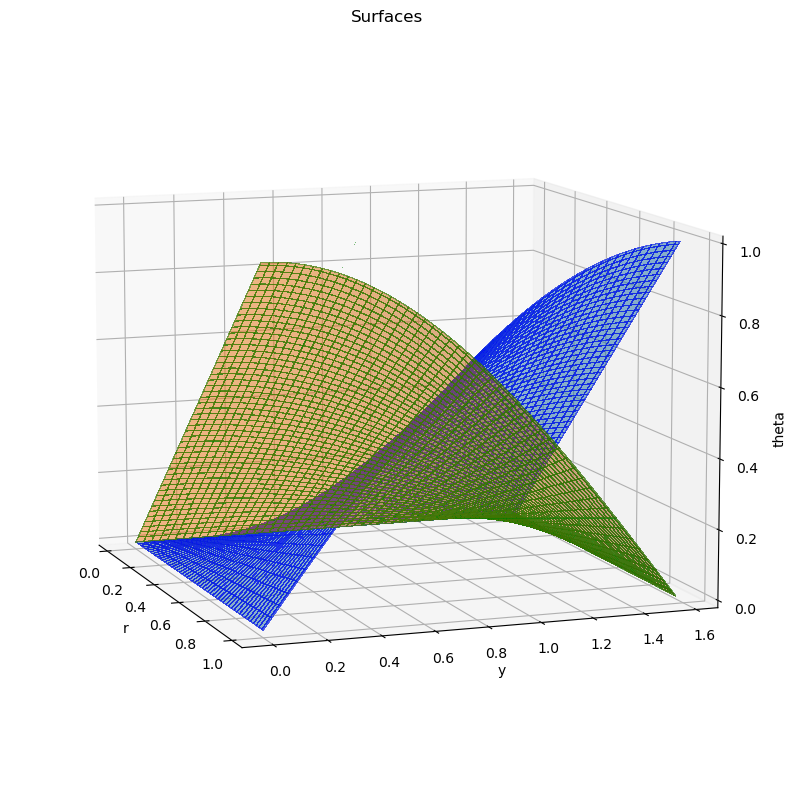

In [12]:
fig = plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes(projection="3d")
ax.plot_surface(R, THETA, y1, rstride=2, cstride=2, alpha=0.5, antialiased=False, shade=True, linewidth=0.1, edgecolor='blue')
ax.plot_surface(R, THETA, y2, rstride=2, cstride=2, alpha=0.5, antialiased=False, shade=True, linewidth=0.1, edgecolor='green')
ax.set_xlabel('r')
ax.set_ylabel('y')
ax.set_zlabel('theta')
ax.set_title('Surfaces')
ax.view_init(10,-20)
plt.show

## Study

In [13]:
def make_study(algo):
    # uses vizier, r, theta from global (read, not write)
    study_spec = {
        "display_name" : "CustomOpt_"+algo,
        "study_spec" : {
            "algorithm" : algo,
            "parameters" : [
                {
                    "parameter_id" : "r",
                    "double_value_spec" : {
                        "min_value" : np.min(r),
                        "max_value" : np.max(r)
                    }
                },
                {
                    "parameter_id" : "theta",
                    "double_value_spec" : {
                        "min_value" : np.min(theta),
                        "max_value" : np.max(theta)
                    }

                }
            ],
            "metrics" : [
                {
                    "metric_id" : "y1",
                    "goal" : "MINIMIZE"
                },
                {
                    "metric_id" : "y2",
                    "goal" : "MAXIMIZE" 
                }
            ]
        }
    }
    study = vizier.create_study(parent=PARENT, study=study_spec)
    return study

In [14]:
study_random = make_study("RANDOM_SEARCH")

In [15]:
study_random.name, study_random.display_name

('projects/691911073727/locations/us-central1/studies/4116282997372',
 'CustomOpt_RANDOM_SEARCH')

## Evaluations

In [16]:
def y1_eval(r,theta):
    return r*np.sin(theta)

def y2_eval(r,theta):
    return r*np.cos(theta)

def metrics(trial, r, theta):
    y1 = y1_eval(r,theta)
    y2 = y2_eval(r,theta)
    m1 = {"metric_id" : "y1", "value" : y1}
    m2 = {"metric_id" : "y2", "value" : y2}
    return [m1, m2]

## Trials

In [17]:
def trial_runner(tname, max_trials):
    trial_id = 0
    while int(trial_id) < max_trials:
        suggestions = vizier.suggest_trials(
            {
                "parent": tname,
                "suggestion_count" : 5,
                "client_id" : "client1"
            }
        )

        for suggestion in suggestions.result().trials:
            trial_id = suggestion.name.split("/")[-1]
            trial = vizier.get_trial({"name" : suggestion.name})

            if trial.state in ["COMPLETED", "INFEASIBLE"]:
                continue

            for param in trial.parameters:
                if param.parameter_id == "r": 
                    r = param.value
                elif param.parameter_id == "theta":
                    theta = param.value

            vizier.add_trial_measurement(
                {
                    "trial_name": suggestion.name,
                    "measurement": {
                        "metrics": metrics(suggestion.name, r, theta)
                    }               
                }
            )

            response = vizier.complete_trial(
                {
                    "name" : suggestion.name,
                    "trial_infeasible": False
                }
            )

In [18]:
trial_runner(study_random.name, 100)

## Answers

In [19]:
def plot_result(study):
    trials = vizier.list_trials({"parent": study.name})
    
    try_r = [x.parameters[0].value for x in trials.trials]
    try_theta = [x.parameters[1].value for x in trials.trials]
    try_y1 = [x.measurements[0].metrics[0].value for x in trials.trials]
    try_y2 = [x.measurements[0].metrics[1].value for x in trials.trials] 
    
    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = plt.axes(projection="3d")
    ax.plot_surface(R, THETA, y1, rstride=2, cstride=2, alpha=0.5, antialiased=False, shade=True, linewidth=0.1, edgecolor='blue')
    ax.plot_surface(R, THETA, y2, rstride=2, cstride=2, alpha=0.5, antialiased=False, shade=True, linewidth=0.1, edgecolor='green')
    for i, j, k, h in zip(try_r, try_theta, try_y1, try_y2):
        ax.plot([i,i], [j,j], [k,h], color='red')
    ax.set_xlabel('r')
    ax.set_ylabel('y')
    ax.set_zlabel('theta')
    ax.set_title('Surfaces')
    ax.view_init(10,-20)
    
    plt.show

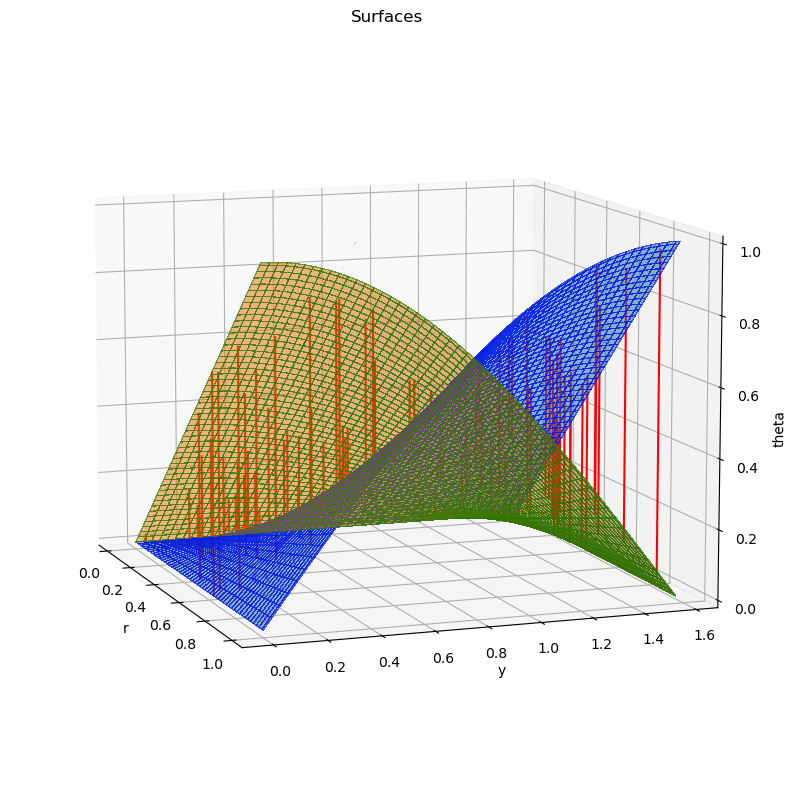

In [20]:
plot_result(study_random)

Optimal answer (so far ....):

In [32]:
def optimals(study):
    otrials = vizier.list_optimal_trials({"parent": study.name})
    print("r = {}".format(otrials.optimal_trials[-1].parameters[0].value))
    print("theta = {}".format(otrials.optimal_trials[-1].parameters[1].value))
    print("y1 = {}".format(otrials.optimal_trials[-1].measurements[0].metrics[0].value))
    print("y2 = {}".format(otrials.optimal_trials[-1].measurements[0].metrics[1].value))
    print("Trial ID = {}".format(otrials.optimal_trials[-1].name.split("/")[-1]))

In [33]:
optimals(study_random)

r = 0.7213217321599767
theta = 0.05468901955682264
y1 = 0.03942871697145737
y2 = 0.7202433044216753
Trial ID = 88


## Vizier Algorithm

In [34]:
study_viz = make_study("ALGORITHM_UNSPECIFIED")

In [35]:
trial_runner(study_viz.name, 100)

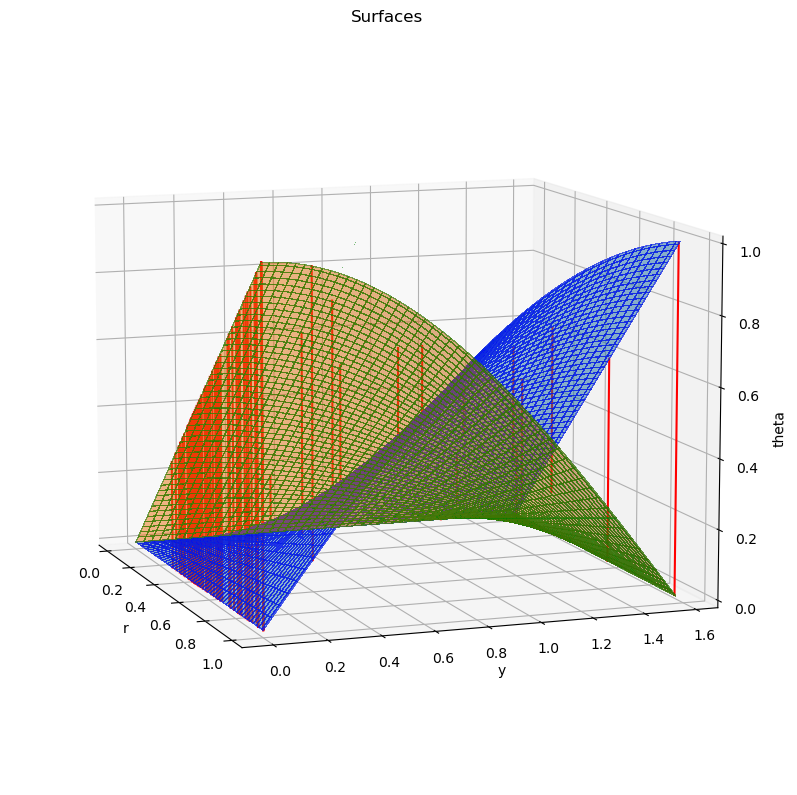

In [36]:
plot_result(study_viz)

In [37]:
optimals(study_viz)

r = 1.0
theta = 0.0
y1 = 0.0
y2 = 1.0
Trial ID = 16


## Remove Study

In [181]:
vizier.delete_study({"name": study_random.name})

In [ ]:
vizier.delete_study({"name": study_viz.name})